## Basic Tensorflow Operations

In [1]:
import tensorflow as tf

input = tf.constant([1, 4, 2, 43, 32, 3, 5, 6])
x = tf.reshape(input, [-1, 2])
a, b = tf.unstack(x, num = 2, axis = 1)
print(tf.reduce_sum(a - b))

tf.Tensor(-16, shape=(), dtype=int32)


In [2]:
@tf.function
def f(input):
  sum = 0
  for i in range(input.shape[0]):
    if i % 2 == 0:
      sum -= input[i]
    else:
      sum += input[i]
    # OR:
    # sum += (float(i % 2 == 0) - .5) * 2. * input[i]
  return sum
  
input = tf.constant([1, 4, 2, 43, 32, 3, 5, 6])
print(f(input))

tf.Tensor(16, shape=(), dtype=int32)


In [3]:
input = tf.constant([1, 4, 2, 43, 32, 3, 5, 6])
class CustomModel(tf.keras.models.Model):
  def call(self, input):
    x = tf.reshape(input, [-1, 2])
    a, b = tf.unstack(x, num = 2, axis = 1)
    return tf.reduce_sum(a - b)
    
model = CustomModel()
print(model(input))

tf.Tensor(-16, shape=(), dtype=int32)


# Lab 1: Convolutional Neural Networks

This notebook contains the key concepts and steps to implementing a Convolutional Neural Network.
Implementing the tasks below should give you an idea of how this method for image classification works.

## STEP 0: Get an idea about the dataset

### Nothing to be done here

**CIFAR** - Canadian Institute For Advanced Research.

CIFAR-10 and CIFAR-100 datasets were developed by the researchers at the CIFAR institute.

This dataset has 60.000 color (depth 3) images 32x32 (WxH) of objects from 10 classes:
- 0: airplane
- 1: automobile
- 2: bird
- 3: cat
- 4: deer
- 5: dog
- 6: frog
- 7: horse
- 8: ship
- 9: truck.

These are really small images and suitable for the purposes of this lab: we want to learn 
how to implement a convolutional neural network, without painfully waiting for the training to end.

The images are indeed very small compared to modern photographs. It can be challenging to see what exactly is represented in some of them. This low resolution is likely the cause of the limited performance that top-of-the-line algorithms are able to achieve on the dataset.

On this dataset it is relatively straightforward to achieve 80% classification accuracy.
Using deep CNNs a top performance above 90% accuracy is achieved.



170498071/170498071 [==============================] - 2s 0us/step
Train shape: X=(50000, 32, 32, 3), y=(50000, 1)
Test shape: X=(10000, 32, 32, 3), y=(10000, 1)


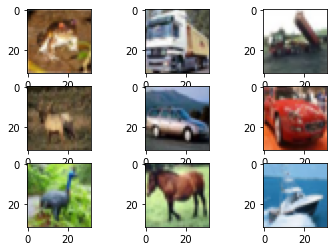

In [4]:
# Version I
from keras.datasets import cifar10
from keras.utils import to_categorical

import matplotlib.pyplot as plt

# download cifar data and split into train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# summarize the loaded dataset
# 50,000 training samples and 10,000 test samples (size: 32x32x3)
print('Train shape: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test shape: X=%s, y=%s' % (X_test.shape, y_test.shape))

# plot first 9 images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i])
# show the figure
plt.show()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteAVQLBE/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteAVQLBE/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='~/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,

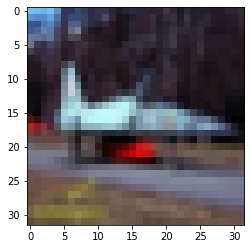

8


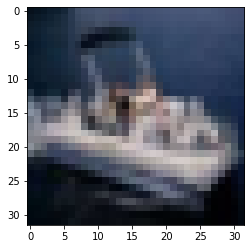

4


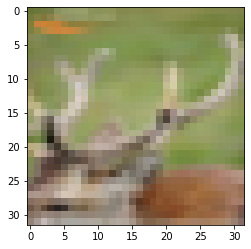

9


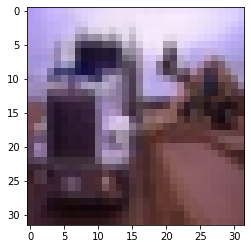

4


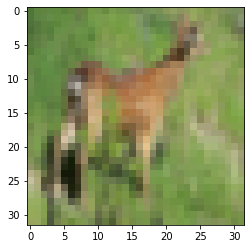

5


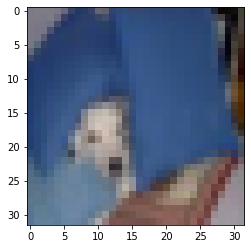

4


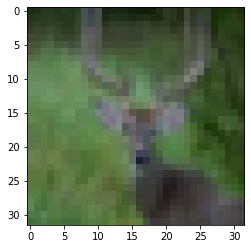

3


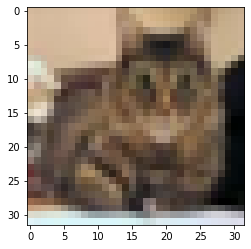

0


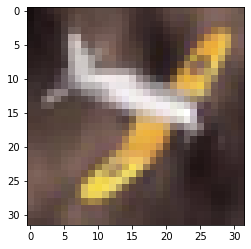

3


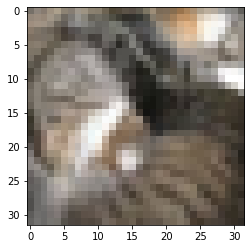

8


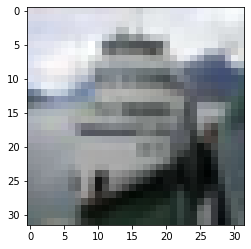

3


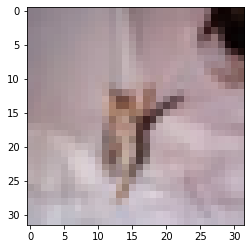

5


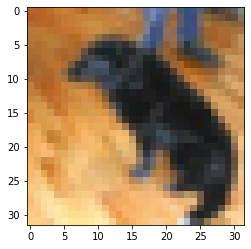

8


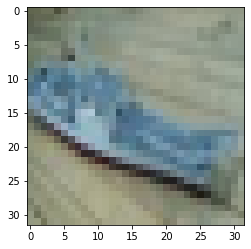

9


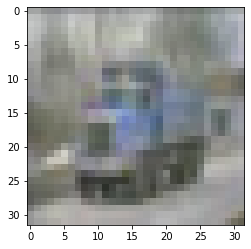

2


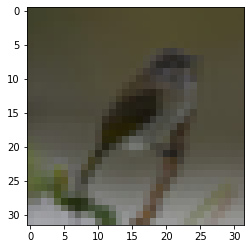

6


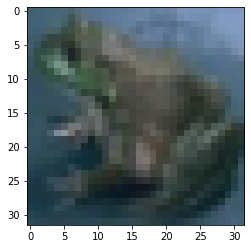

6


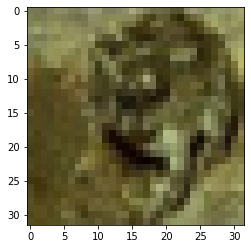

0


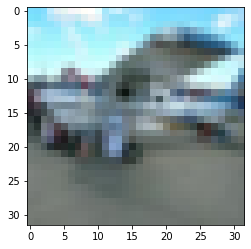

4


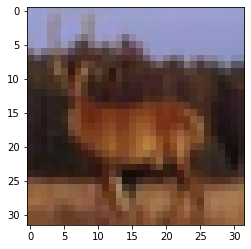

6


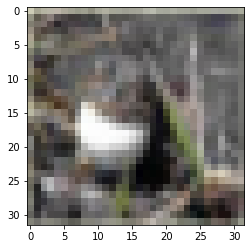

8


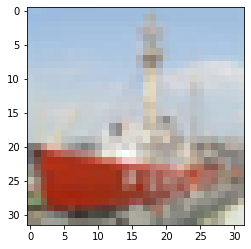

1


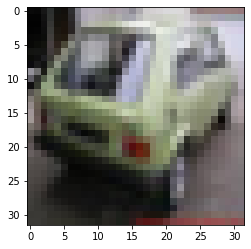

8


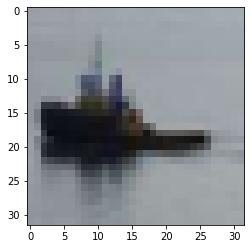

7


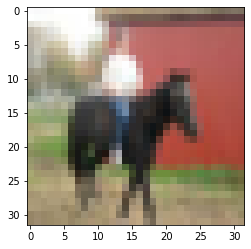

5


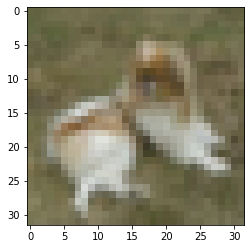

1


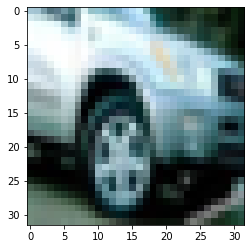

3


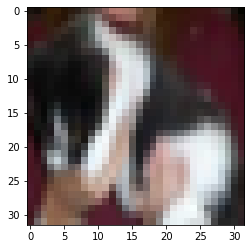

6


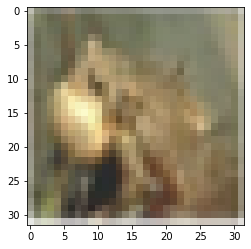

3


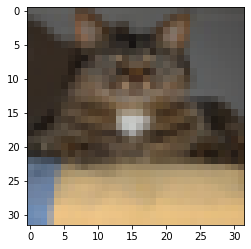

8


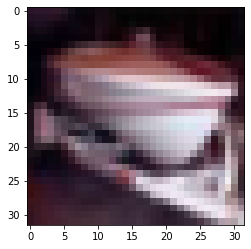

7


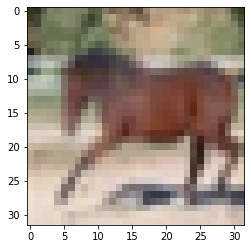

0


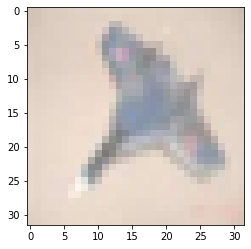

7


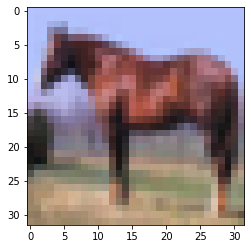

8


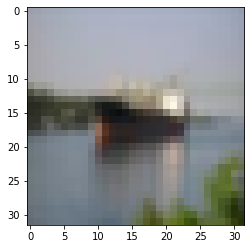

7


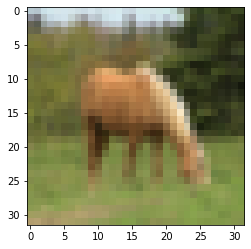

7


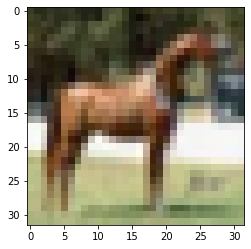

6


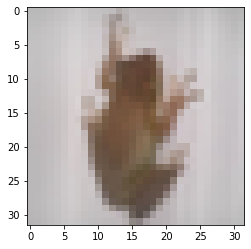

6


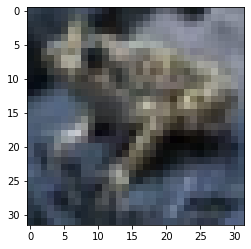

4


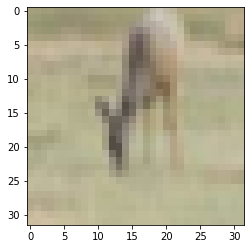

6


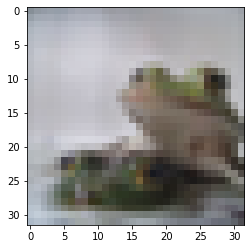

7


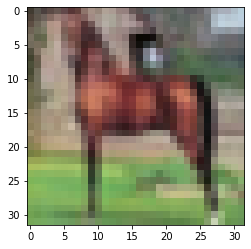

0


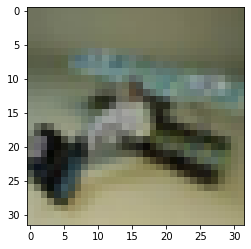

8


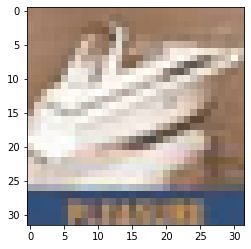

0


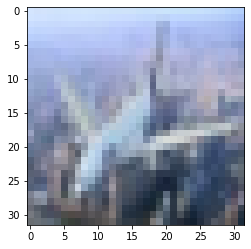

3


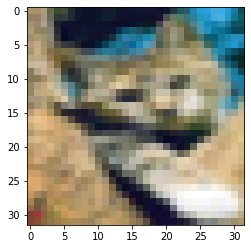

1


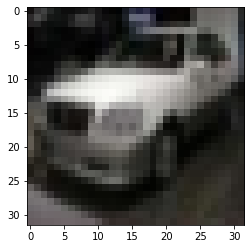

0


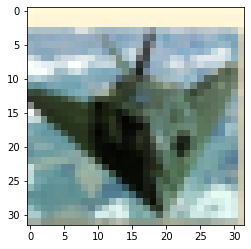

8


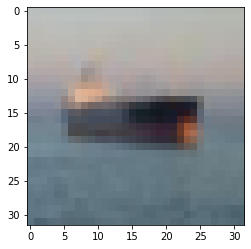

1


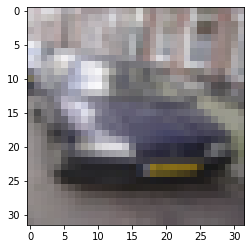

5


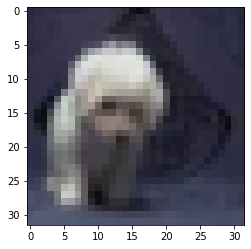

8


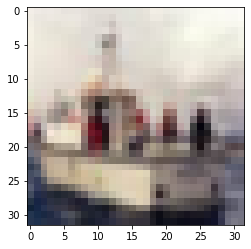

9


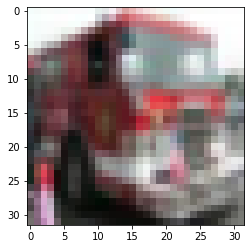

0


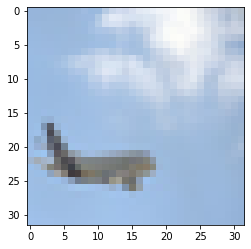

5


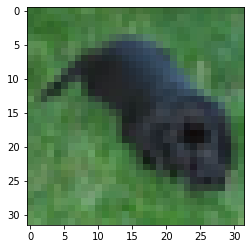

5


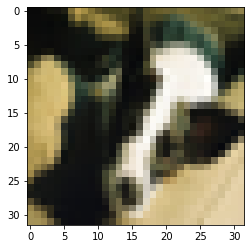

8


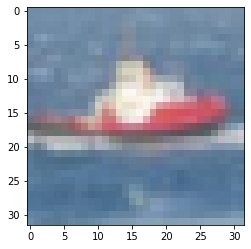

3


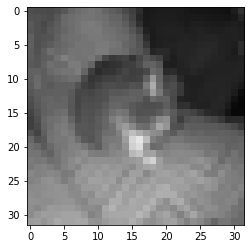

9


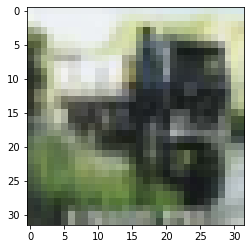

1


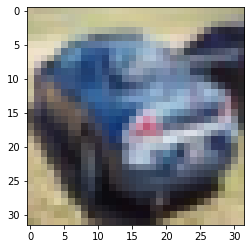

1


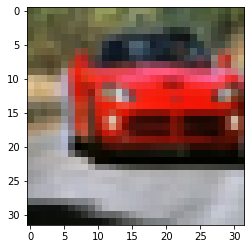

3


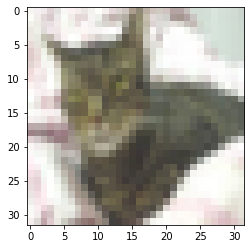

9


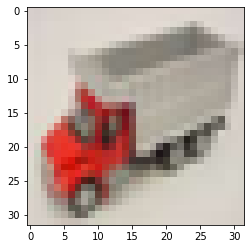

1


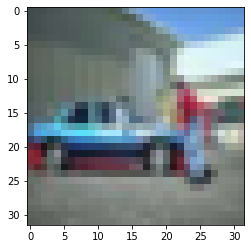

2


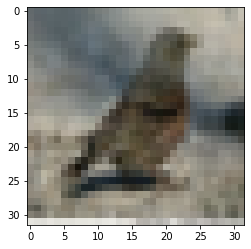

9


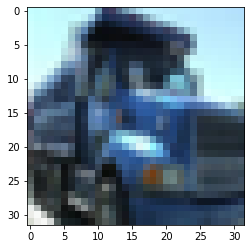

2


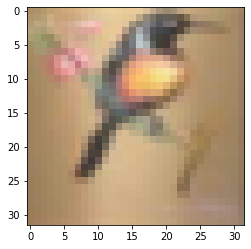

4


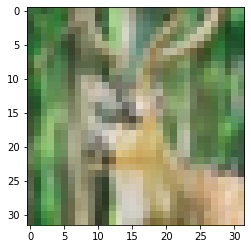

0


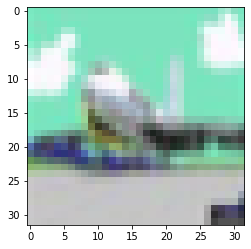

5


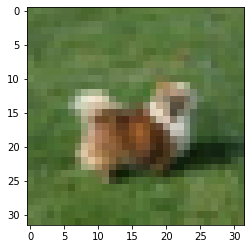

1


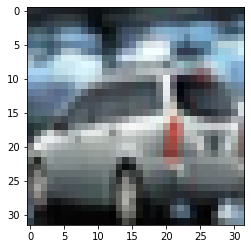

9


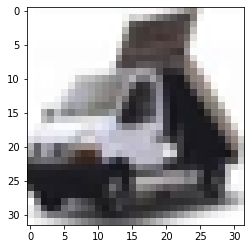

2


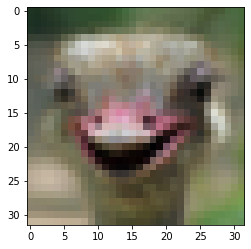

7


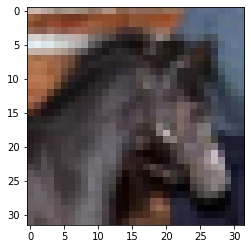

4


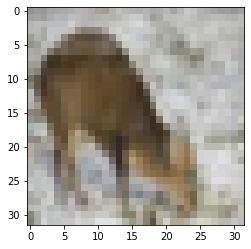

9


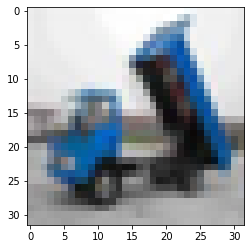

9


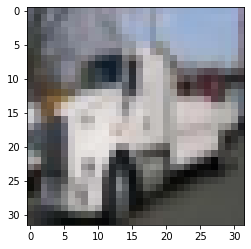

1


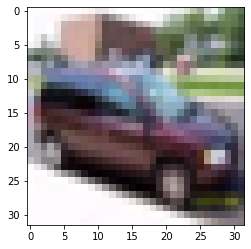

9


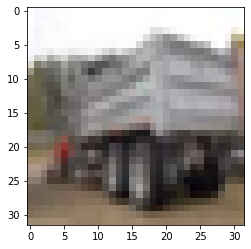

3


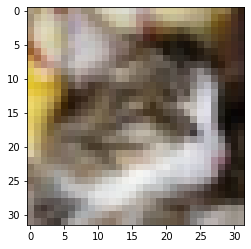

2


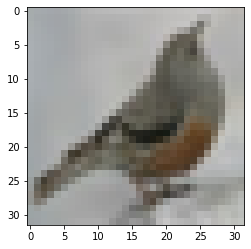

3


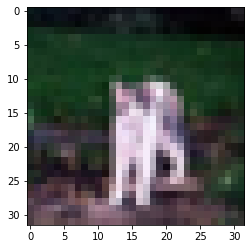

7


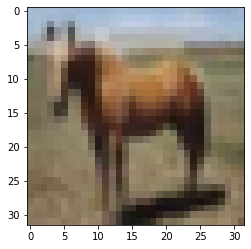

0


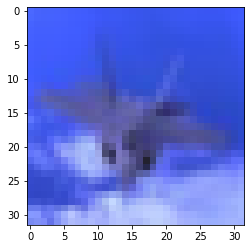

5


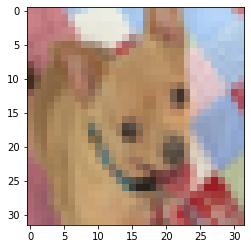

2


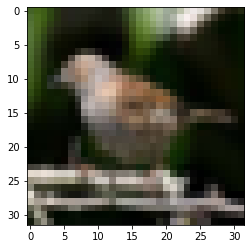

3


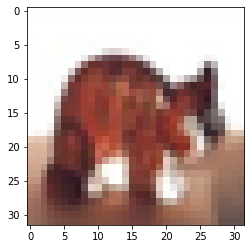

3


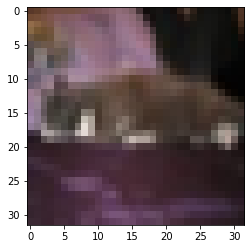

9


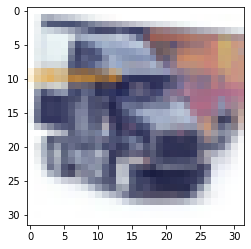

3


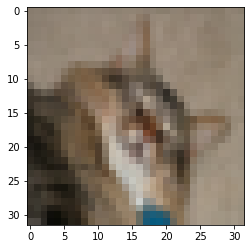

4


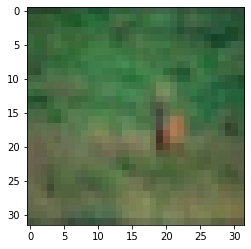

7


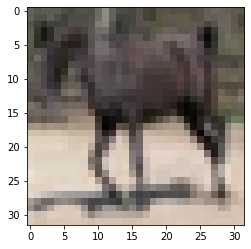

1


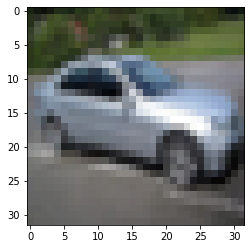

9


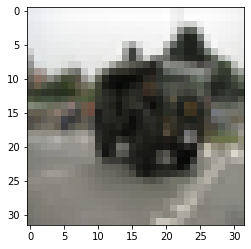

2


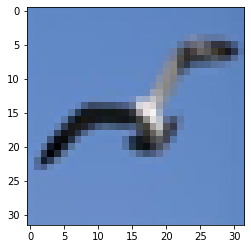

3


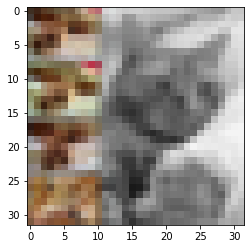

3


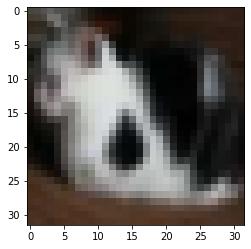

9


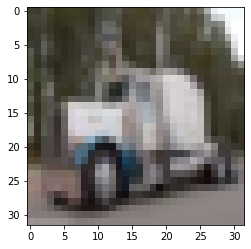

2


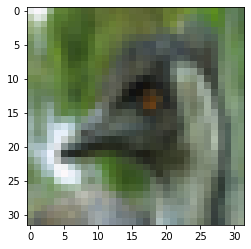

4


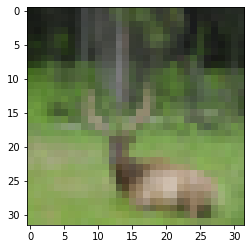

In [5]:
# Version II
import math
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.layers as layers

import matplotlib.pyplot as plt

"""
  In this scenario ds is a dictionary with "train" and "test" keys pointing to the coresponding sets.
  The meta variable conveys descriptive information such as: number of samples per split, input
  size, name of the article accompanying dataset, etc. You can iterate through samples by casting
  the dataset to numpy 
"""

ds, meta = tfds.load('cifar10', as_supervised = True, with_info = True)
train_ds, test_ds = ds['train'], ds['test']
print(meta)

for idx, (np_image, label) in enumerate(tfds.as_numpy(test_ds)):
  if idx % 100 == 1:
    print(label)
    plt.imshow(np_image)
    plt.show()

## STEP 1: Load the data
### 1.1. Load the dataset
### 1.2. Reshape the inputs

> Reshape the dataset inputs X_train and X_test to fit the model. Here 50000 is the number of samples, 32 is the width/height, 3-for the channels of color - Keras requires this 3rd dimension.

### 1.3. One-hot encode the target column
> E.g. if the input image contains a plane, the 3rd element of the target column is going to be 1 and the rest of the elements 0.




In [6]:
def load_data():
    # TODO 1.1. load the dataset
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    # TODO 1.2. reshape the inputs (train and test) - NOT REQUIRED (the dataset already had the right dimensions)
    X_train = X_train.reshape(len(X_train), 32, 32, 3)
    X_test = X_test.reshape(len(X_test), 32, 32, 3)
    print(X_train.shape, X_test.shape)

    # TODO 1.3. one-hot encode the target column (train and test)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    print("y_train[0] one hot: ", y_train[0])

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data()


(50000, 32, 32, 3) (10000, 32, 32, 3)
y_train[0] one hot:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## STEP 2: Prepare the data
### 2.1. Convert the pixels 
> From integers to floats.

### 2.2. Normalize the pixel values 
> From [0, 255] to [0.0, 1.0]. This is optional but in general using smaller values tends to give better results. Try also without this pre-processing and look at the loss.

In [7]:
def prepare_data(train, test):
    # TODO 2.1. convert int to float
    train = train.astype('float32')
    test = test.astype('float32')
    
    # TODO 2.2. normalize to range [0.0, 1.0]
    train_norm = (train / 255.)
    test_norm = (test / 255.)

    # return the normalized images
    return train_norm, test_norm

X_train, X_test = prepare_data(X_train, X_test)

## STEP 3: Build the model

### 3.1. Create the model:
> Sequential() is the easiest way to build a model in Keras. This allows you to build a model layer by layer. There is also Model() - class. Not in the scope of this lab.
         
         
### 3.2. Add layers.
> We can add the layers directly in the constructor (as a list) or later, using add().
  - **L1**: a **convolutional layer** with **32 nodes**. Kernel size is 3 => **3x3 filter** matrix. Note that on the first conv layer we need to specify the input shape. The best parameters for this layer: **padding='same'**, **activation='relu'**.
  - **L2**: In the second (also **conv**) layer we have **32 nodes** and the same parameters as above. 
  - **L3**: **Max Pooling** with **2x2 size** for the filter - can try without it and see what happens with the train time/loss.
  - **L4**: Add a **dropout** layer - commonly used to prevent overfitting. Drop **1/4** of the neurons.
  - **L5**: Add a **convolutional** layer with **64 neurons**, **kernel size 3**, **padding same** and **activation relu**.
  - **L6**: Add a **convolutional** layer with **64 neurons**, **kernel size 3** and **activation relu**.
  - **L7**: Add a **Max Pooling** layer with **filter size 2x2**.
  - **L8**: Add a **Dropout** layer, with **1/4** of the neurons dropped.
  - **L9**: Add a **Flatten** layer - the flatten layer serves as a connection b/w the conv and dense layers. Flatten = squeeze into 1D the activation maps and put them together. (Aka convert matrix to single array).
  - **L10**: Add a **Dense** layer with **512** nodes, **relu** activation.
  - **L11**: Add a **Dropout** layer, where **half** of the neurons are **dropped**.
  - **L12**: Add a **Dense** layer. In this case the Dense layer is used for the output layer: **10 nodes**, for each possible outcome (0 - 10). The activation is **softmax** - makes the outputs to sum up to 1 => interpret them as probabilities.  The model is going to make its prediction based on which option has the highest probability.


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

def build_model():
    ### TODO 3.1. create the model
    model = Sequential()
    
    ### 3.2. add the layers
    
    # TODO L1: add a CONV  layer with 32 nodes, kernel size is 3, padding same, activation relu 
    model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32,32,3)))
    
    # TODO L2: add a CONV layer with 32 nodes, kernel size is 3, activation relu
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    
    # TODO L3: add a Max Pooling layer, 2x2
    model.add(MaxPooling2D(pool_size=2))
    
    # TODO L4: add a Dropout layer, drop 1/4 of the neurons
    model.add(Dropout(0.25))
    
    # TODO L5: add a CONV layer with 64 neurons, kernel size is 3, padding same and the activation is relu
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    
    # TODO L6: add a CONV layer with 64 nodes, kernel size is 3, activation relu
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    
    # TODO L7: add a Max Pooling layer with filter size 2x2
    model.add(MaxPooling2D(pool_size=2))
    
    # TODO L8: add a Dropout layer; drop 1/4 of the neurons
    model.add(Dropout(0.25))
    
    # TODO L9: add a Flatten layer
    model.add(Flatten())
    
    # TODO L10: Add a Dense layer, 512 neurons and activation relu
    model.add(Dense(512, activation='relu'))
    
    # TODO L11: Add a Dropout layer; drop 1/2 of the neurons
    model.add(Dropout(0.5))
    
    # TODO L12: Add a Dense layer, with 10 neurons and softmax as activation
    model.add(Dense(10, activation='softmax'))

    return model

model = build_model()

## STEP 4: Compile the model
> Here we are going to need and optimizer, a loss function and a metric.
  - **Optimizer** 
     - controls the learning rate. Here: **Adam** - a good optimizer for many cases.
       Adam adjusts the learning rate throughout training.
       Learning rate = how fast the optimal weights for the model are computed.
       The LR value involves a trade-off b/w speed (larger lr) and accuracy (smaller lr).
     - Other optimizers: https://keras.io/optimizers/  
  - **Loss**
     - **categorical_crossentropy** - a common choice for classification ( > 2 classes). The lower the score, the better.
     - Other losses: https://keras.io/losses/ 
  - **Metric**
     - **accuracy** - not the best choice but it is ok to make things easier.

In [9]:
# TODO 4. compile() the model using the adam optimizer, categorical crossentropy as loss and accuracy as metric
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

## STEP 5: Train the model
> Use the **fit()** function with the parameters:
  - training data: **train_X** (images)
  - target data: **train_y** (labels)
  - **validation data**: **X_test**, **y_test** (periodically used during training to measure the performance of the model against data it has not seen before.)
  - number of **epochs**: the number of times the model is cycling through the data. Not to large as the model only improves up to a certain point. Set to **100** in this case.
  - **shuffle** the data for batches.
  - a **batch size** of **64** is ok. 

In [10]:
# TODO 5. Fit the model with the training data, validation data, 100 epochs, bach size 64, with shuffle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, shuffle=True)

Epoch 1/100
782/782 [==============================] - 14s 8ms/step - loss: 1.5958 - accuracy: 0.4169 - val_loss: 1.2623 - val_accuracy: 0.5458
Epoch 2/100
782/782 [==============================] - 6s 7ms/step - loss: 1.1602 - accuracy: 0.5864 - val_loss: 1.0073 - val_accuracy: 0.6500
Epoch 3/100
782/782 [==============================] - 6s 7ms/step - loss: 0.9735 - accuracy: 0.6547 - val_loss: 0.8784 - val_accuracy: 0.6907
Epoch 4/100
782/782 [==============================] - 6s 7ms/step - loss: 0.8860 - accuracy: 0.6888 - val_loss: 0.8360 - val_accuracy: 0.7123
Epoch 5/100
782/782 [==============================] - 8s 10ms/step - loss: 0.8001 - accuracy: 0.7219 - val_loss: 0.7566 - val_accuracy: 0.7345
Epoch 6/100
782/782 [==============================] - 7s 10ms/step - loss: 0.7559 - accuracy: 0.7361 - val_loss: 0.7082 - val_accuracy: 0.7517
Epoch 7/100
782/782 [==============================] - 6s 7ms/step - loss: 0.7092 - accuracy: 0.7520 - val_loss: 0.6927 - val_accuracy: 0.7

## STEP 6: Save the model

From this model we are interested in the weights. Thus, in order to use the model later, we need to save the weights learned at training time.

In [11]:
model.save_weights('cifar_cnn.h5')

## STEP 7: Make predictions
> Use the **predict()** function to see the actual predictions that our model has made for the test data.The predict() function gives an array with 10 numbers - the probaility that th input is 0-9. The array index with the highest value is the prediction made by the model.

> Additionally: re-load the trained model. Essentially what we have to do here is to rebuild the model and load in the saved weights.

In [12]:
import numpy as np

def load_test_model():
    # TODO 7.1. (re)build the model
    model = build_model()
    # TODO 7.2. load the model's saved weights.
    model.load_weights('cifar_cnn.h5')
    # TODO 7.3. Predict the class of the first 10 images in the test set
    predictions = model.predict(X_test)
    
    # 7.4. Print the predictions done by the model ([7, 2, 1, 0, 4])
    print("Predictions: \n", np.argmax(predictions, axis=1))
    
    # 7.5. Check our predictions against the ground truths ([7, 2, 1, 0, 4])
    print("Ground truth: \n", y_test[:10])
    
load_test_model()

313/313 [==============================] - 1s 2ms/step
Predictions: 
 [3 8 8 ... 5 0 7]
Ground truth: 
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


## STEP 8: Learning Curves

Plot the learning curves to get an idea about how the model learns, overfitting, etc.

> 80.740


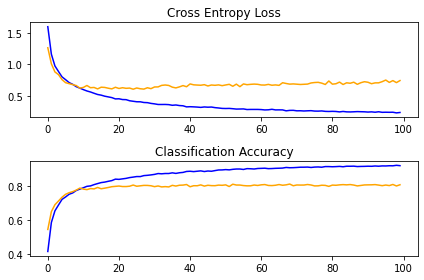

In [13]:
import sys

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')

	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')

	plt.tight_layout()

	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	plt.savefig(filename + '_plot.png')

	plt.show()

# evaluate model
_, acc = model.evaluate(X_test, y_test, verbose=0)

print('> %.3f' % (acc * 100.0))

# learning curves
summarize_diagnostics(history)

## BONUS

With the knowledge achieved through this lab, build a simplified CNN which is able to classify the digits in the MNIST dataset. The network does not need to have more than 2 convolutional layers in order for the performance to be satisfactory in terms of accuracy.

Note that the MNIST dataset is lighter than CIFAR as the images are grayscale (only one color channel).

image shape:  (28, 28)
y_train[0] one hot:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Epoch 1/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1833 - accuracy: 0.9452 - val_loss: 0.0587 - val_accuracy: 0.9809
Epoch 2/3
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0730 - accuracy: 0.9770 - val_loss: 0.0408 - val_accuracy: 0.9865
Epoch 3/3
1/1 [==============================] - 0s 74ms/step
Predictions for the first 4 test samples: 
 [[1.6608849e-08 6.3616361e-09 4.5775724e-07 2.3039949e-05 5.5202237e-10
  3.8141197e-09 3.6498558e-14 9.9997509e-01 1.5467544e-08 1.4683254e-06]
 [4.8622728e-06 3.5645958e-06 9.9998128e-01 1.4940062e-07 3.7541278e-10
  2.3666419e-10 9.7699594e-06 2.6619521e-11 3.1369649e-07 1.4662506e-10]
 [4.4109538e-06 9.9844521e-01 7.9997117e-05 1.8961211e-05 9.5520110e-04
  1.2040508e-05 1.0168291e-05 3.6177342e-04 1.1145186e-04 8.9912726e-07]
 [9.9997926e-01 1.5004284e-11 6.8038339e-06 1.6271039e-07 1.2627962e-07
  5.7979999e-08 4.0049354

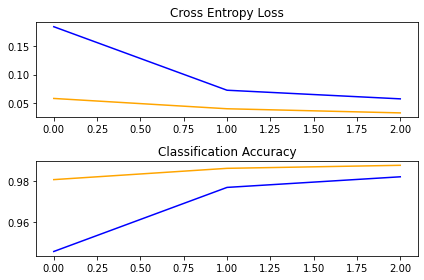

In [20]:
import os

from keras.datasets import mnist
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

import matplotlib.pyplot as plt

# TODO B1. Download mnist data and split into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Plot the first image in the dataset
plt.imshow(X_train[0])

# Check the image shape
print("image shape: ", X_train[0].shape)

######################
# B2. Prepare the data
######################

# TODO B2.1. Normalize the pixel values from [0, 255] to [-0.5, 0.5].
X_train_norm = (X_train / 255. - .5)
X_test_norm = (X_test / 255. - .5)

# TODO B2.2. Reshape the dataset inputs X_train and X_test to fit the model 
# train: (60000, 28, 28, 1), test: (10000, 28, 28, 1)
X_train = X_train_norm.reshape(60000, 28, 28, 1)
X_test = X_test_norm.reshape(10000, 28, 28, 1)

# TODO B2.3. One-hot encode the target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("y_train[0] one hot: ", y_train[0])

#####################
# B3. Build the model
#####################

# TODO B3.1. Create model
model = Sequential()

# TODO B3.2. Add conv layer - 64 nodes, 3x3, relu
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
# TODO B3.3. Add conv layer - 32 nodes, 3x3, relu
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
# TODO B3.4. Add max pooling layer - 2x2 pool size
model.add(MaxPooling2D())
# TODO B3.5. Add a dropout layer - 0.5
model.add(Dropout(0.5))
# TODO B3.6. Add flatten layer
model.add(Flatten())
# TODO B3.7. Add dense layer - 10 nodes, softmax
model.add(Dense(units=10, activation='softmax'))
#######################
# B4. Compile the model
#######################

# TODO B4. Optimizer: adam, Loss: categorical_crossentropy, Metric: accuracy.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#####################
# B5. Train the model
#####################

# TODO B5. Use the fit() function with the parameters:
#   - training data: train_X (images)
#   - target data: train_y (labels)
#   - validation data: X_test, y_test 
#   - number of epochs: 3
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

######################
# B6. Make predictions
######################

# Predict
print("Predictions for the first 4 test samples: \n", model.predict(X_test[:4]))

# Compare with the actual results
print("Actual values in the test set: \n", y_test[:4])

#####################
# B7. Using the model
#####################

# TODO B7. Save model
model.save_weights('mnist_cnn.h5')

##############################
# B8. Plot the learning curves
##############################

# TODO B8.1. Evaluate model
_, acc = model.evaluate(X_test, y_test)

print('> %.3f' % (acc * 100.0))

# TODO B8.2. Plot the learning curves
summarize_diagnostics(history)